In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
def read_system_info(file_path):
    """
    Read system information from a file.

    Args:
        file_path (str): The path to the file containing system information.

    Returns:
        dict: A dictionary containing the system information, with keys representing
              the information categories and values representing the corresponding values.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    info = {}
    for line in lines:
        # Check if there is more than one element after splitting
        if len(line.strip().split(': ')) == 2:
            key, value = line.strip().split(': ')
            info[key] = value

    return info

In [2]:
"""
This code reads CSV files from the "Results" directory, extracts device information from the file names, and replaces the device names with the corresponding GPU or CPU names from the system_info.txt file. The data is then concatenated into a single dataframe called combined_dataframe.
"""
combined_dataframe=pd.DataFrame()
id=1
for file in os.listdir("Results"):
    file_name=file
    data=pd.read_csv("Results/"+file_name+'/'+file_name+'.csv')
    data['ID']=id
    data['Type']=data["Device"]
    data['Device']=data['Device'].replace('cuda',read_system_info("Results/"+file_name+'/system_info.txt')['GPU name'])
    data['Device']=data['Device'].replace('cpu',read_system_info("Results/"+file_name+'/system_info.txt')['CPU name'])
    combined_dataframe=pd.concat([combined_dataframe,data],axis=0)
    id+=1

In [3]:

def plot_analysis(combined_dataframe,device_type):
    """
    Plots the analysis of execution time, memory usage, and throughput
    for different devices based on the given combined dataframe.

    Parameters:
    combined_dataframe (pandas.DataFrame): The combined dataframe containing the data.

    Returns:
    None
    """
    # Filter dataframe for CPU data
    df = combined_dataframe[combined_dataframe['Type'] == device_type]

    # Get unique devices
    unique_devices = df['Device'].unique()

    # Set up subplots
    fig, axs = plt.subplots(3, 1, figsize=(20, 15))

    # Plot Execution Time
    axs[0].set_title('Execution Time vs Array Size (Log Scale)')
    axs[0].set_xlabel('Array Size')
    axs[0].set_ylabel('Execution Time (ms)')
    for device in unique_devices:
        device_data = df[df['Device'] == device]
        axs[0].plot(device_data['Array Size'], device_data['Execution Time'], label=device)
    axs[0].legend()
    axs[0].set_yscale('log')

    # Plot Memory Usage
    axs[1].set_title('Memory Usage vs Array Size')
    axs[1].set_xlabel('Array Size')
    axs[1].set_ylabel('Memory Usage (MB)')
    for device in unique_devices:
        device_data = df[df['Device'] == device]
        axs[1].plot(device_data['Array Size'], device_data['Memory Usage'], label=device)
    axs[1].legend()

    # Plot Throughput
    axs[2].set_title('Throughput vs Array Size')
    axs[2].set_xlabel('Array Size')
    axs[2].set_ylabel('Throughput')
    for device in unique_devices:
        device_data = df[df['Device'] == device]
        axs[2].plot(device_data['Array Size'], device_data['Throughput'], label=device)
    axs[2].legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    
    plt.show()
    # save the plot in Analysis_Results folder
    fig.savefig('Analysis_Results/'+device_type+'.png')
    plt.close()

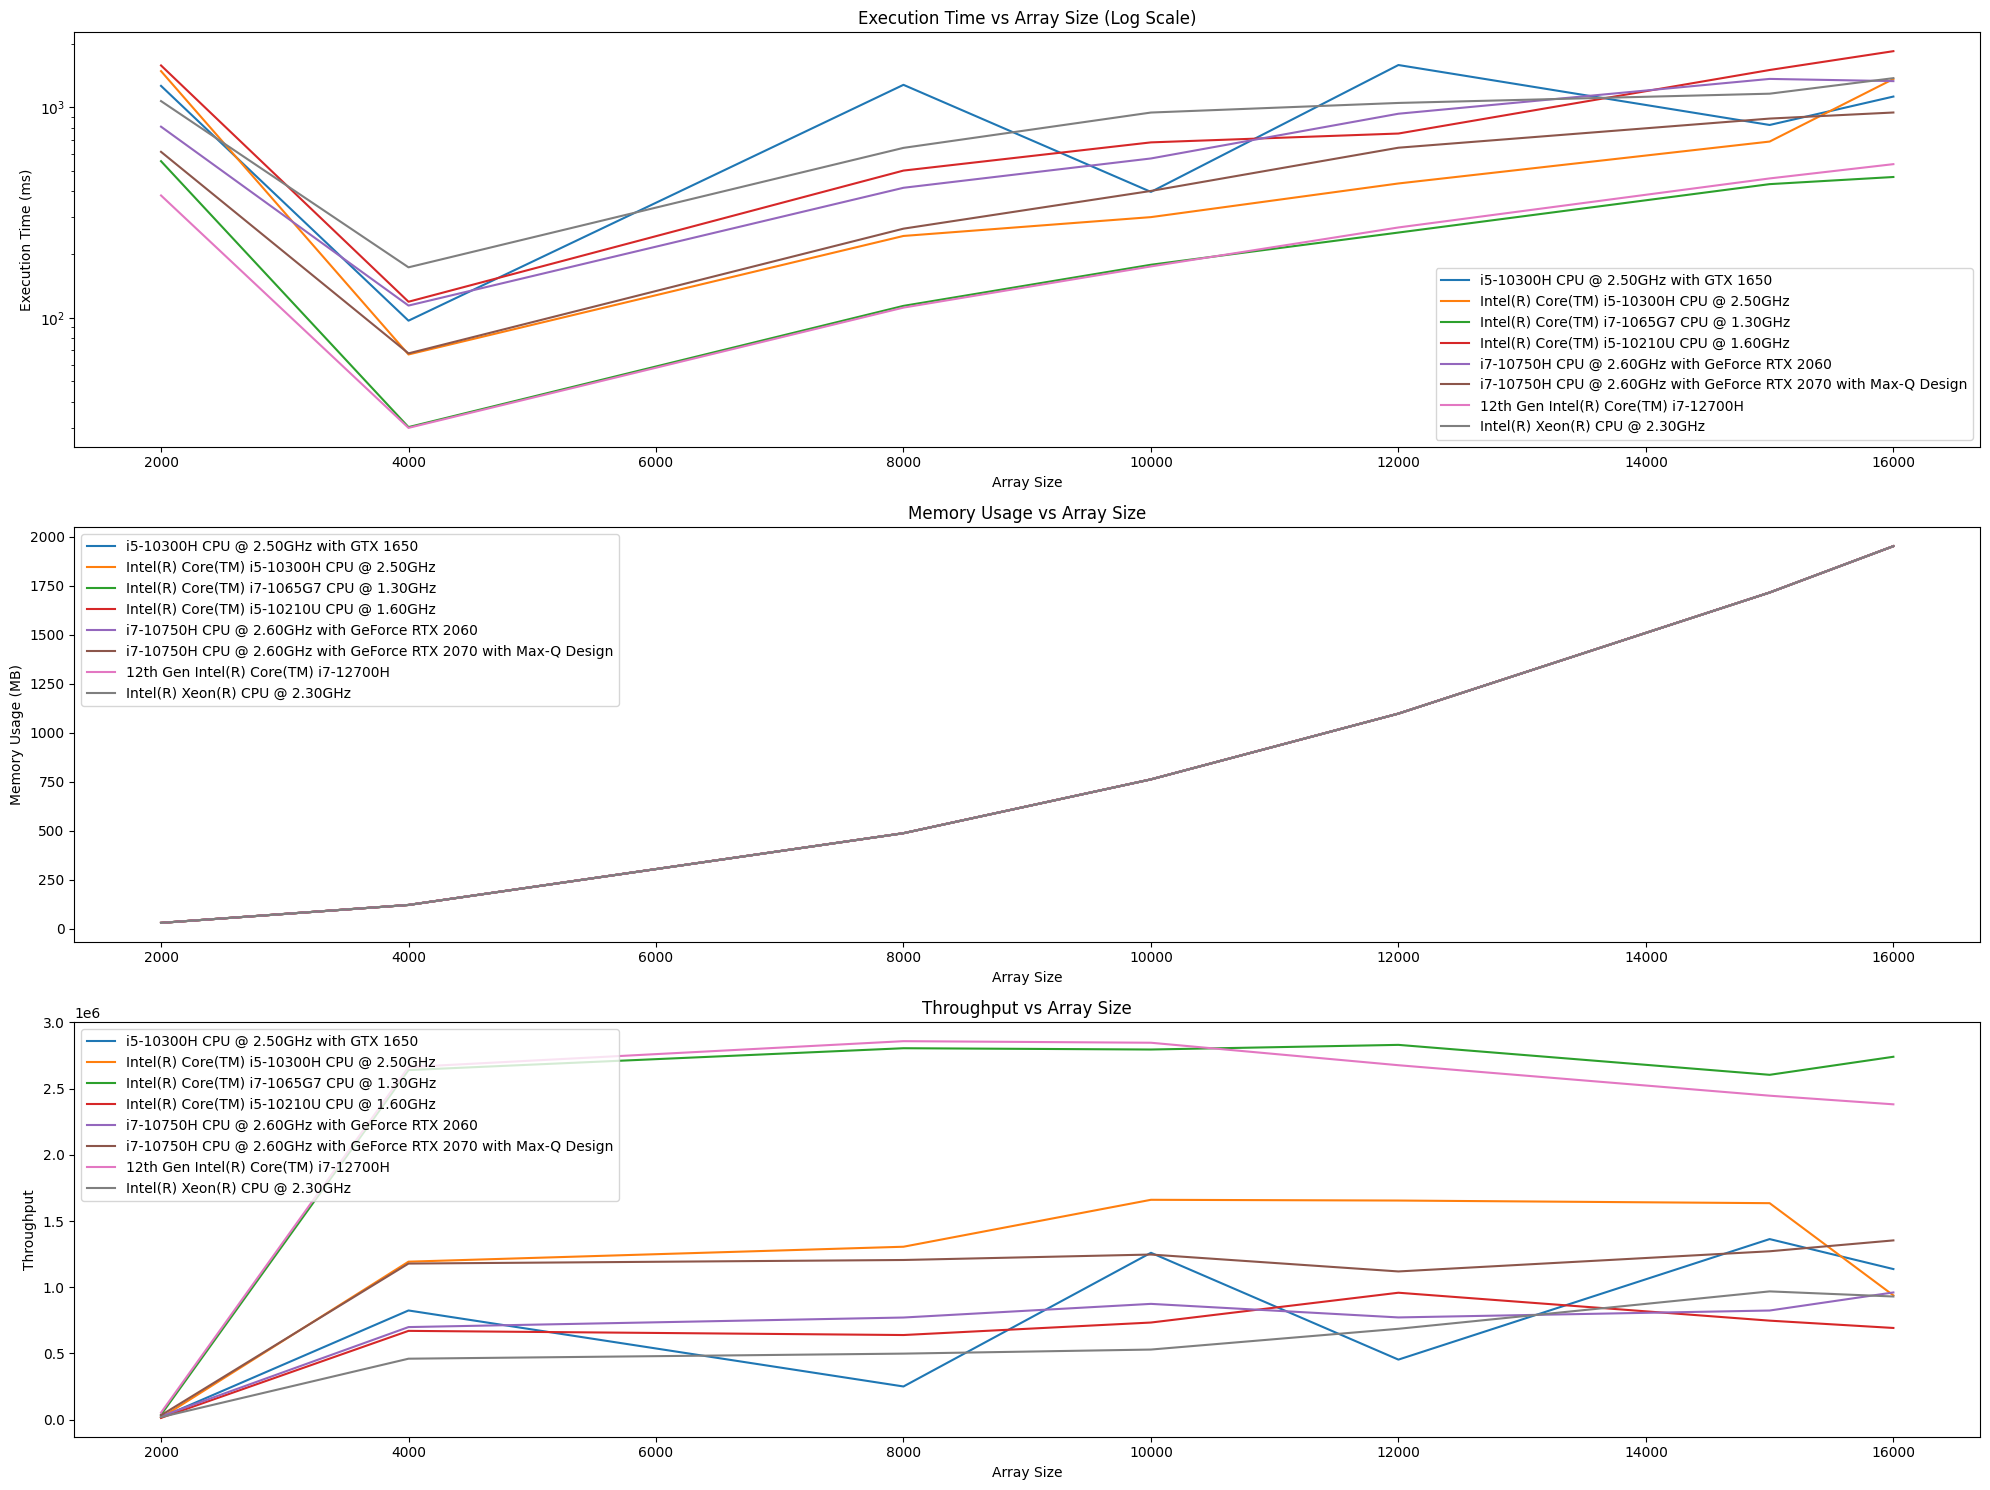

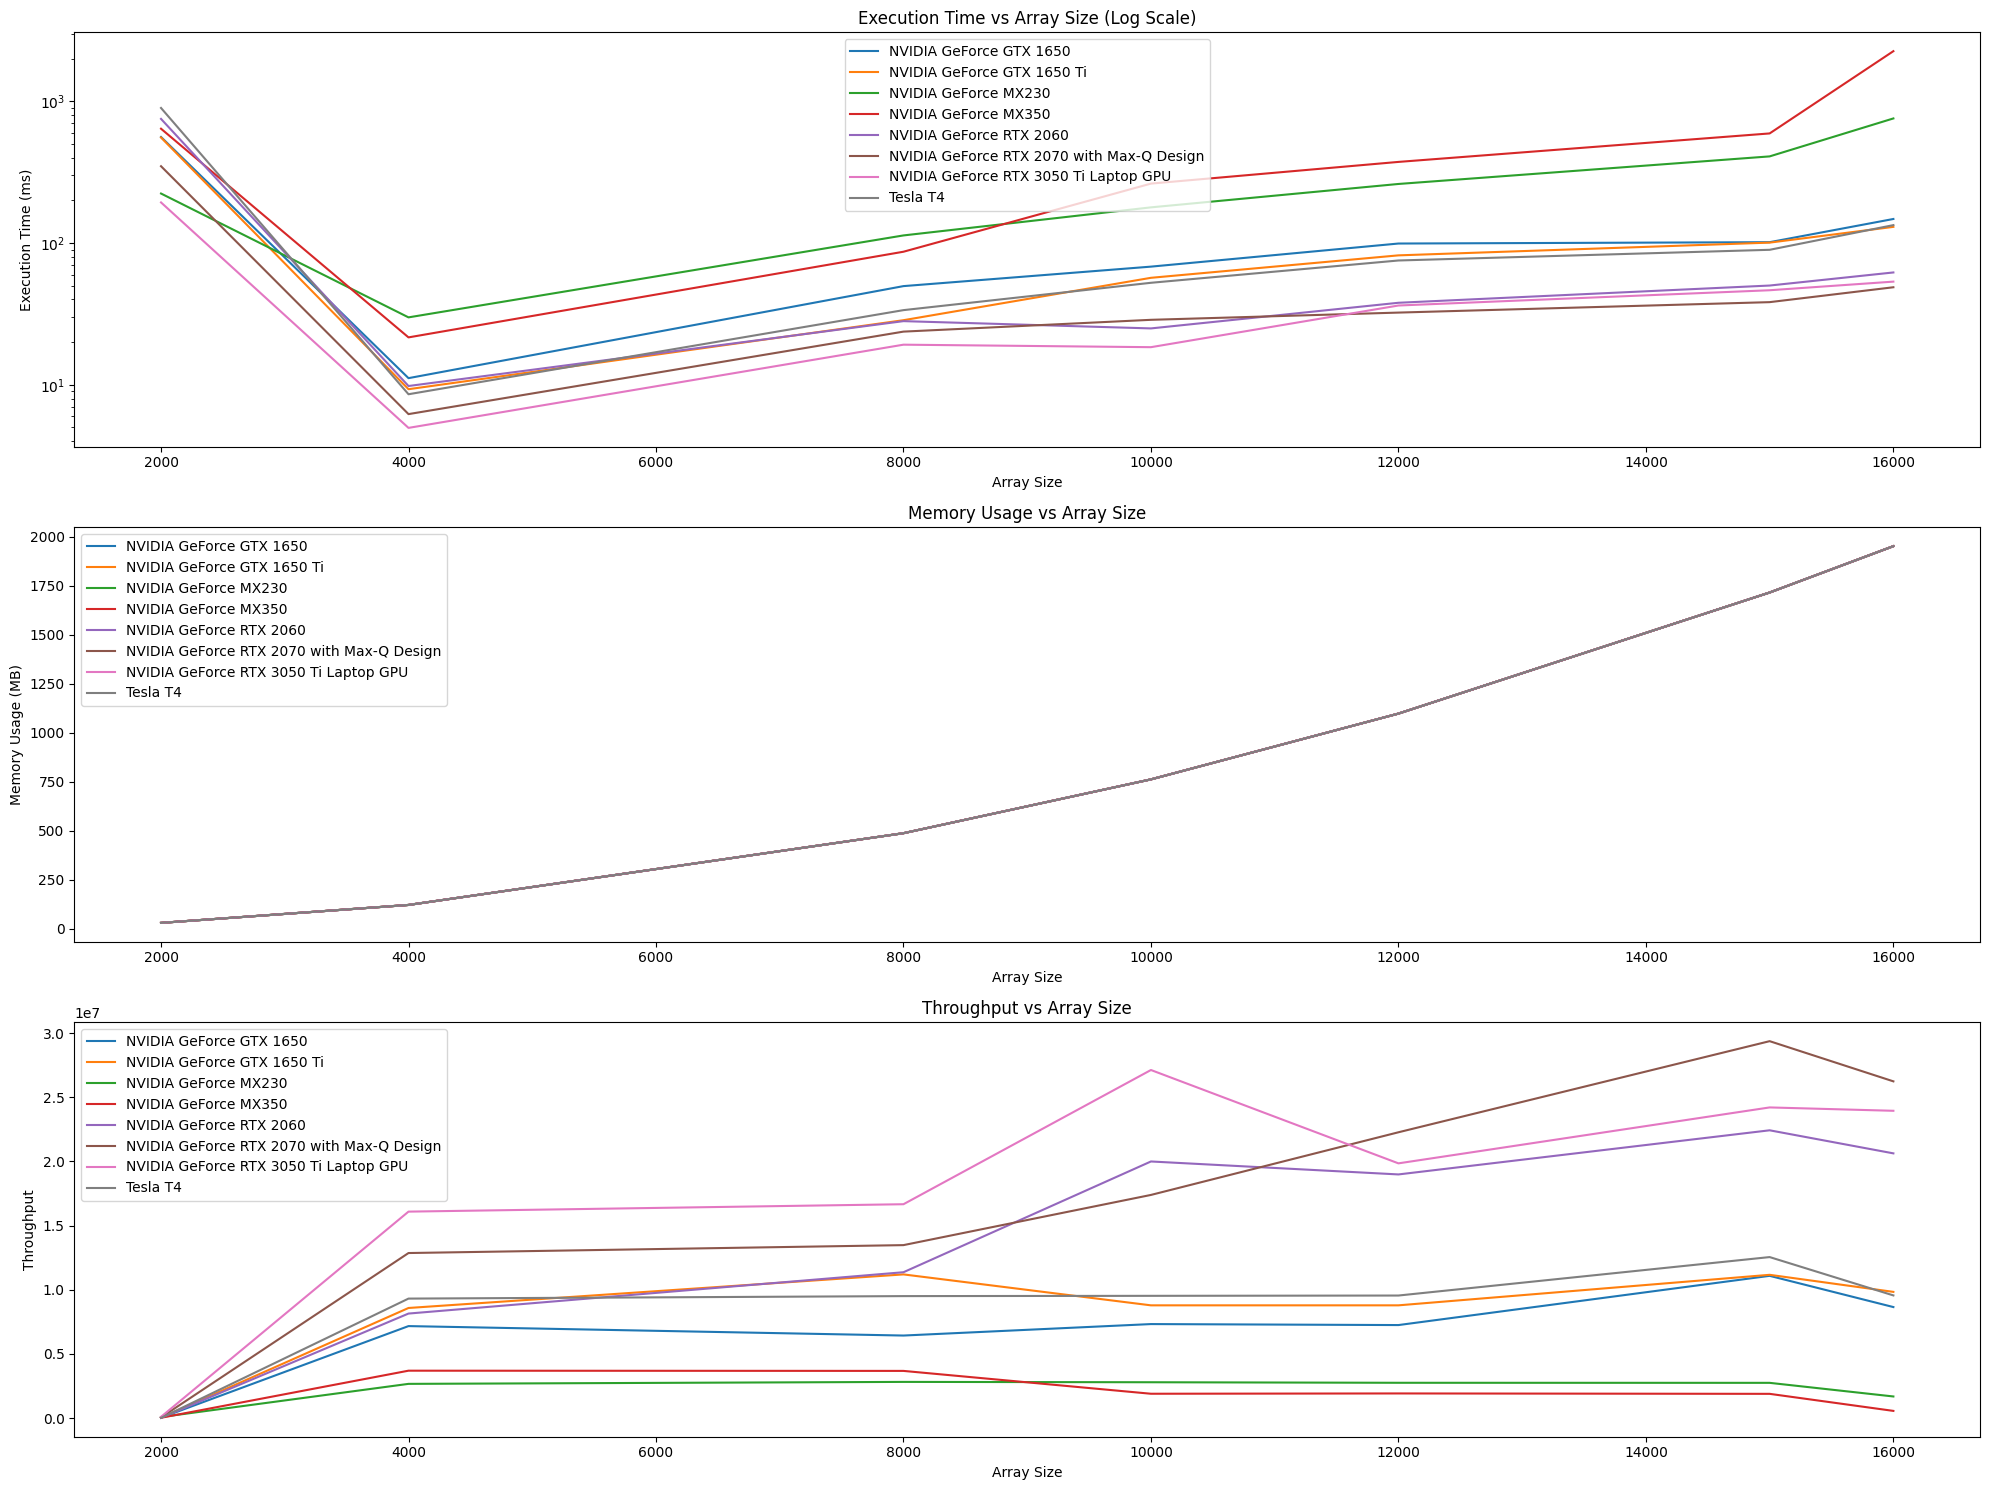

In [4]:
plot_analysis(combined_dataframe,'cpu')
plot_analysis(combined_dataframe,'cuda')

In [5]:
"""
Calculates the speed-up factor for different array sizes and IDs based on the execution time data in the combined_dataframe.

Parameters:
- combined_dataframe: DataFrame containing the execution time data for different array sizes and IDs.

Returns:
- speed_up_factor: Dictionary containing the speed-up factor for each array size and ID combination.
"""
speed_up_factor={}
for array_size in combined_dataframe['Array Size'].unique():
    speed_up_factor[array_size]={}
    for id in combined_dataframe['ID'].unique():
        speed_up_factor[array_size][id]=combined_dataframe[(combined_dataframe['ID']==id) & (combined_dataframe['Array Size']==array_size)]['Execution Time'].iloc[0]/combined_dataframe[(combined_dataframe['ID']==id) & (combined_dataframe['Array Size']==array_size)]['Execution Time'].iloc[1]

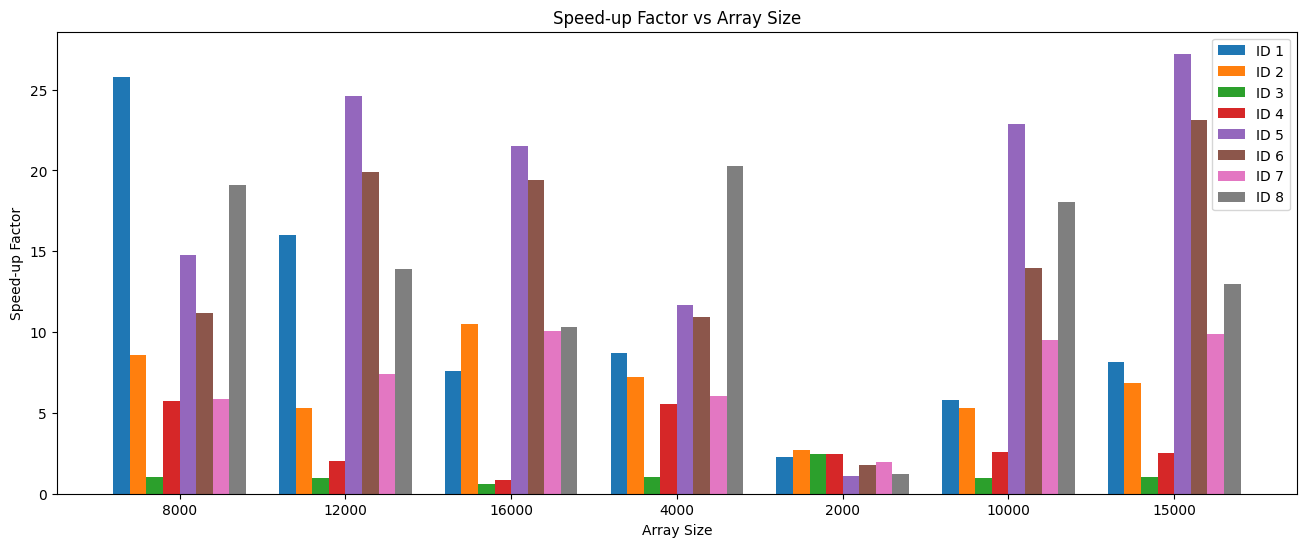

In [6]:
plt.figure(figsize=(16, 6))
# Calculate the width for each bar
bar_width = 0.1  # Adjust this value based on your preference

# Find the common array sizes across all IDs
common_array_sizes = set.intersection(*(set(speed_up_factor.keys()) for i in range(1, len(combined_dataframe['ID'].unique()) + 1)))

for i in range(1, len(combined_dataframe['ID'].unique()) + 1):
    # Only consider array sizes that are common across all IDs
    valid_data = [speed_up_factor[size][i] for size in common_array_sizes]
    
    # Calculate the position for each set of bars
    positions = np.arange(len(valid_data)) + (i - 1) * bar_width
    
    # Plot bars
    plt.bar(positions, valid_data, width=bar_width, label=f'ID {i}')

plt.xlabel('Array Size')
plt.ylabel('Speed-up Factor')
plt.title('Speed-up Factor vs Array Size')
plt.xticks(np.arange(len(common_array_sizes)) + (len(combined_dataframe['ID'].unique()) - 1) * bar_width / 2, common_array_sizes)
plt.legend()

# Save the plot before calling plt.show()
plt.savefig('Analysis_Results/Speed_up_Factor.png')

# Display the plot
plt.show()

In [7]:
# Read the existing README content
with open("README.md", 'r') as file:
    readme = file.readlines()

# Extract the existing entries from the README
existing_entries = []
found_table_header = False

for line in readme:
    if found_table_header:
        if "|" in line:
            entry = line.split("|")[1:4]  # Extract ID, CPU, GPU from the line
            entry = [col.strip() for col in entry]
            existing_entries.append(entry)

    if line.strip() == "| ID | CPU | GPU |":
        found_table_header = True
    elif found_table_header:
        # If the table header has been found, stop searching for it and continue with the rest of the file
        found_table_header = False

# Get unique IDs from combined_dataframe
unique_ids = combined_dataframe['ID'].unique()

# Check if each unique ID already exists in the README, if not, add it
for id in unique_ids:
    id_str = str(id)
    cpu = combined_dataframe[combined_dataframe['ID'] == id]['Device'].iloc[0]
    gpu = combined_dataframe[combined_dataframe['ID'] == id]['Device'].iloc[1]
    
    # Check if the entry already exists
    if [id_str, cpu, gpu] not in existing_entries:
        # Add the entry to the existing_entries list
        existing_entries.append([id_str, cpu, gpu])

# Sort the entries by ID
sorted_entries = sorted(existing_entries, key=lambda x: int(x[0]) if x[0].isdigit() else 0)

# Update the README content
updated_readme = []
found_table_header = False

for line in readme:
    if found_table_header:
        if "|" in line:
            continue  # Skip existing entries
        else:
            found_table_header = False

    if line.strip() == "| ID | CPU | GPU |":
        found_table_header = True
        # Append the updated table header
        updated_readme.append(line)

        # Append the sorted entries
        for entry in sorted_entries:
            updated_readme.append("| " + " | ".join(entry) + " |\n")
    else:
        updated_readme.append(line)

# Write the updated README content back to the file
with open("README.md", 'w') as file:
    file.writelines(updated_readme)